In [34]:
from bs4 import BeautifulSoup as bs
from itertools import cycle
from torrequest import TorRequest
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import collections
from random import choice
import time
import requests
import datetime as dt
import pandas as pd
import re

In [2]:
def get_user_agent():
    
    ua_list = ["Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/38.0.2125.111 Safari/537.36",
               "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/28.0.1500.72 Safari/537.36",
               "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10) AppleWebKit/600.1.25 (KHTML, like Gecko) Version/8.0 Safari/600.1.25",
               "Mozilla/5.0 (Windows NT 6.1; WOW64; rv:33.0) Gecko/20100101 Firefox/33.0",
               "Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/38.0.2125.111 Safari/537.36",
               "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/38.0.2125.111 Safari/537.36",
               "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_5) AppleWebKit/600.1.17 (KHTML, like Gecko) Version/7.1 Safari/537.85.10",
               "Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko",
               "Mozilla/5.0 (Windows NT 6.3; WOW64; rv:33.0) Gecko/20100101 Firefox/33.0",
               "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/38.0.2125.104 Safari/537.36"
               ]
    
    return random.choice(ua_list)

In [3]:
def get_proxies():
    
    proxy_url = 'https://github.com/TheSpeedX/PROXY-List/blob/master/http.txt'

    response = requests.get(proxy_url)
    soup = bs(response.content, 'lxml').find_all('td',{'class':'blob-code blob-code-inner js-file-line'})
    proxies = ["http://"+i.text for i in soup]

    keys = []
    for i in range(len(proxies)):
        keys.append('http')

    proxy_list = [{L2 : L1} for (L1,L2) in zip(proxies, keys)]  
    #print(proxy_list)
    return random.choice(proxy_list)

In [4]:
test_url = 'https://www.google.com/'
tech_url = 'https://www.techpowerup.com/gpu-specs/'

In [5]:
def parse_html(url):
    
    header = {'User-Agent': get_user_agent()}
    proxy = get_proxies()
    
    try:
        #time.sleep(random.randint(45,700))
        #time.sleep(random.randint(150,400))
        response = requests.get(url, headers= header, proxies= proxy, timeout= 3)
        status_code = response.status_code
        content = response.content
        soup = bs(content, "lxml")
        print(header)
        print(proxy)
        
        return soup, status_code
    
    except Exception as e:
        print(f"Error: {e}")
    
        
        #print(header)
        #print(proxy)
    

In [6]:
soup, status_code = parse_html(tech_url)

{'User-Agent': 'Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/38.0.2125.111 Safari/537.36'}
{'http': 'http://177.93.48.74:999'}


In [7]:
print(soup)

<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="utf-8"/>
<title>GPU Database | TechPowerUp</title>
<meta content="width=device-width, initial-scale=1" name="viewport"/>
<link href="https://tpucdn.com" rel="preconnect"/>
<meta content="TechPowerUp" name="application-name"/>
<meta content="Graphics card and GPU database with specifications for products launched in recent years. Includes clocks, photos, and technical details." name="description"/>
<link as="style" crossorigin="" href="https://tpucdn.com/css/style-v1653412523850.css" rel="preload stylesheet"/>
<link as="font" crossorigin="" href="https://tpucdn.com/css/fonts/tpu-body-regular-v1653412523850.woff2" rel="preload" type="font/woff2"/>
<link as="font" crossorigin="" href="https://tpucdn.com/css/fonts/tpu-body-bold-v1653412523850.woff2" rel="preload" type="font/woff2"/>
<link as="font" crossorigin="" href="https://tpucdn.com/css/fonts/opensans-condbold-v1653412523850.woff2" rel="preload" type="font/woff2"/>
<meta content="

In [8]:
def gpu_link(soup):

    temp = []

    for i in soup.find('table', class_="processors").find_all('tr'):
        next_page = i.find('a')
        if next_page != None:
            page_list = next_page.attrs['href']
            temp.append(tech_url.strip('/gpu-spec/')+page_list)

    return temp

In [9]:
temp_list = gpu_link(soup)

In [10]:
print(temp_list)

['https://www.techpowerup.com/gpu-specs/geforce-rtx-3060.c3682', 'https://www.techpowerup.com/gpu-specs/geforce-rtx-3060-ti.c3681', 'https://www.techpowerup.com/gpu-specs/geforce-rtx-3080.c3621', 'https://www.techpowerup.com/gpu-specs/geforce-rtx-3090-ti.c3829', 'https://www.techpowerup.com/gpu-specs/geforce-rtx-3050-8-gb.c3858', 'https://www.techpowerup.com/gpu-specs/geforce-rtx-3070.c3674', 'https://www.techpowerup.com/gpu-specs/radeon-rx-6600-xt.c3774', 'https://www.techpowerup.com/gpu-specs/geforce-rtx-2060.c3310', 'https://www.techpowerup.com/gpu-specs/radeon-rx-6950-xt.c3875', 'https://www.techpowerup.com/gpu-specs/geforce-rtx-3070-ti.c3675', 'https://www.techpowerup.com/gpu-specs/radeon-rx-6600.c3696', 'https://www.techpowerup.com/gpu-specs/geforce-gtx-1050-ti.c2885', 'https://www.techpowerup.com/gpu-specs/radeon-rx-6650-xt.c3898', 'https://www.techpowerup.com/gpu-specs/geforce-gtx-1650.c3366', 'https://www.techpowerup.com/gpu-specs/geforce-rtx-3090.c3622', 'https://www.techpowe

In [12]:
def gpu_dict(temp_list):
    
    col_label_list = []
    data_list = []
    temp_dict = {}

    for idx, i in enumerate(temp_list):
        print(f"-----{i}-------")
        time.sleep(random.randint(45,150))
        soup, status_code = parse_html(temp_list[idx])
        print(status_code)
        if status_code != 200:
            soup, status_code = parse_html(temp_list[idx])
            print(status_code)

        title = soup.find('h1', class_="gpudb-name").text
        #title_list.append(title)

        gpu_stats = soup.find('div').find_all('dl')

        temp_dict[title] = {}
        for jdx, j in enumerate(gpu_stats):
            column_label = j.find('dt').text
            data = j.find('dd').text.replace('\n',"").replace('\t',"")
            #col_label_list.append(column_label)
            #data_list.append(data)
            temp_dict[title][column_label] = data

        for key, value in zip(column_label, data):
            temp_dict[title][column_label] = data       
            
    return temp_dict

In [13]:
temp_dict = gpu_dict(temp_list)

-----https://www.techpowerup.com/gpu-specs/geforce-rtx-3060.c3682-------
{'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/28.0.1500.72 Safari/537.36'}
{'http': 'http://187.216.90.46:53281'}
200
-----https://www.techpowerup.com/gpu-specs/geforce-rtx-3060-ti.c3681-------
{'User-Agent': 'Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/38.0.2125.111 Safari/537.36'}
{'http': 'http://121.156.109.108:8080'}
200
-----https://www.techpowerup.com/gpu-specs/geforce-rtx-3080.c3621-------
{'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_5) AppleWebKit/600.1.17 (KHTML, like Gecko) Version/7.1 Safari/537.85.10'}
{'http': 'http://185.3.214.3:80'}
200
-----https://www.techpowerup.com/gpu-specs/geforce-rtx-3090-ti.c3829-------
{'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10) AppleWebKit/600.1.25 (KHTML, like Gecko) Version/8.0 Safari/600.1.25'}
{'http': 'http://177.6.235.74:8080'}
200
-----https://

In [14]:
print(temp_dict)

{'NVIDIA GeForce RTX 3060': {'Graphics Processor': 'GA106', 'GPU Name': 'GA106', 'GPU Variant': 'GA106-300-A1', 'Architecture': 'Ampere', 'Foundry': 'Samsung', 'Process Size': '8 nm', 'Transistors': '12,000 million', 'Die Size': '276 mm²', 'Release Date': 'Jan 12th, 2021', 'Availability': 'Feb 25th, 2021', 'Generation': 'GeForce 30', 'Predecessor': 'GeForce 20', 'Successor': 'GeForce 40', 'Production': 'Active', 'Launch Price': '329 USD', 'Bus Interface': 'PCIe 4.0 x16', 'Reviews': '60 in our database ', 'Base Clock': '1320 MHz', 'Boost Clock': '1777 MHz', 'Memory Clock': '1875 MHz15 Gbps effective', 'Memory Size': '12 GB', 'Memory Type': 'GDDR6', 'Memory Bus': '192 bit', 'Bandwidth': '360.0 GB/s', 'Shading Units': '3584', 'TMUs': '112', 'ROPs': '48', 'SM Count': '28', 'Tensor Cores': '112', 'RT Cores': '28', 'L1 Cache': '128 KB (per SM)', 'L2 Cache': '3 MB', 'Pixel Rate': '85.30 GPixel/s', 'Texture Rate': '199.0 GTexel/s', 'FP16 (half) performance': '12.74 TFLOPS (1:1)', 'FP32 (float)

In [155]:
def dict_to_df(my_dict):

    df_temp = pd.DataFrame(columns=['Name','SKU','Process(nm)','Die(mm²)','Date','MSRP(USD)','Bus','BaseClock(MHz)','BoostClock(MHz)'
                                   ,'MemoryClock(MHz)','MemorySize(GB)','MemBus(bit)','Bandwidth(GB/s)','ShadingUnits','RTCores'
                                   ,'PixelRate(GPixel/s)','TextureRate(GTexel/s)','FP16','FP32','FP64','TDP'])
    
    df_temp_test = pd.DataFrame(columns=['FP16','FP32','FP64'])

    for key, val in my_dict.items():

        gpu_name = key
        
        if 'Board Number' in val:
            sku = val['Board Number']
            
        proc = val['Process Size'].strip('nm')
        die_size = val['Die Size'].strip('mm²')
        rel_date = val['Release Date'].replace('th,','').replace('st,','').replace('nd,','').replace('rd,','')
        
        if 'Launch Price' in val:
            msrp = val['Launch Price'].strip('USD').split(' ')[0].replace(',','')
            
        bus_interface = val['Bus Interface']
        
        if 'Base Clock' in val:
            base_clock = val['Base Clock'].strip('MHz')
            
        if 'Boost Clock' in val:
            boost_clock = val['Boost Clock'].strip('MHz')
            
        mem_clock = val['Memory Clock'].split(' ')[0]
        mem_size = val['Memory Size'].strip('GB').strip('M')
        mem_type = val['Memory Type']
        mem_bus = val['Memory Bus'].strip('bit')
        band_wid = val['Bandwidth'].strip('GB/s').replace(',','')
        shade_unit = val['Shading Units']
        
        if 'RT Cores' in val:
            rt_cores = val['RT Cores']
            
        pix_rate = val['Pixel Rate'].strip('GPixel/s')
        tex_rate = val['Texture Rate'].strip('GTexel/s').replace(',','')
        tdp = val['TDP'].strip('W')
        
        
        if 'FP16 (half) performance' in val:
            fp16 = val['FP16 (half) performance']
            
            if fp16.split(' ')[1] == 'GFLOPS':
                fp16 = float(fp16.split(' ')[0].replace(',','')) * .001
    
            elif fp16.split(' ')[1] == 'TFLOPS':
                fp16 = float(fp16.split(' ')[0].replace(',',''))
            fp16 = f'{fp16:.8f}'
            
        elif 'FP16 (half) performance' not in val:
            fp16 = None
            
        if 'FP32 (float) performance' in val:  
            fp32 = val['FP32 (float) performance']
            
            if fp32.split(' ')[1] == 'GFLOPS':
                fp32 = float(fp32.split(' ')[0].replace(',','')) * .001
    
            elif fp32.split(' ')[1] == 'TFLOPS':
                fp32 = float(fp32.split(' ')[0].replace(',',''))
            fp32 = f'{fp32:.8f}'
                
        elif 'FP32 (float) performance' not in val:
            fp32 = None
            
        if 'FP64 (double) performance' in val:
            fp64 = val['FP64 (double) performance']
            
            if fp64.split(' ')[1] == 'GFLOPS':
                fp64 = float(fp64.split(' ')[0].replace(',','')) * .001
                fp64 = f'{fp64:.8f}'
                
        elif 'FP64 (double) performance' not in val:
            fp64 = None
        
        #df_temp_test = df_temp_test.append({'FP16':fp16,'FP32':fp32,'FP64':fp64}, ignore_index = True)

        df_temp = df_temp.append({'Name':gpu_name,'SKU':sku,'Process(nm)':proc,'Die(mm²)':die_size,'Date':rel_date,'MSRP(USD)':msrp
                                  ,'Bus':bus_interface,'BaseClock(MHz)':base_clock,'BoostClock(MHz)':boost_clock,'MemoryClock(MHz)':mem_clock
                                  ,'MemorySize(GB)':mem_size,'MemBus(bit)': mem_bus,'Bandwidth(GB/s)':band_wid,'ShadingUnits':shade_unit
                                  ,'RTCores':rt_cores,'PixelRate(GPixel/s)':pix_rate,'TextureRate(GTexel/s)':tex_rate,'FP16':fp16,'FP32':fp32
                                  ,'FP64':fp64,'TDP':tdp}, ignore_index = True)

        df_temp['Date'] = pd.to_datetime(df_temp['Date'])
        df = df_temp.astype({'Process(nm)': 'int64','Die(mm²)':'int64','MSRP(USD)':'int64','BaseClock(MHz)':'int64','BoostClock(MHz)':'int64'
                             ,'MemoryClock(MHz)':'int64','MemorySize(GB)':'int64','MemBus(bit)':'int64','Bandwidth(GB/s)':'float64','ShadingUnits':'int64'
                             ,'RTCores':'int64','PixelRate(GPixel/s)':'float64','TextureRate(GTexel/s)':'float64','FP16':'float64','FP32':'float64'
                             ,'FP64':'float64','TDP':'int64'}) 

    df.to_csv('GPU_Specs.csv')

    return df

In [156]:
df =  dict_to_df(temp_dict) 

In [157]:
df.head()

,Name,SKU,Process(nm),Die(mm²),Date,MSRP(USD),Bus,BaseClock(MHz),BoostClock(MHz),MemoryClock(MHz),...,MemBus(bit),Bandwidth(GB/s),ShadingUnits,RTCores,PixelRate(GPixel/s),TextureRate(GTexel/s),FP16,FP32,FP64,TDP
0,NVIDIA GeForce RTX 3060,PG190 SKU 60,8,276,2021-01-12,329,PCIe 4.0 x16,1320,1777,1875,...,192,360.0,3584,28,85.30,199.0,12.740,12.740,0.1990,170
1,NVIDIA GeForce RTX 3060 Ti,PG142 SKU 20,8,392,2020-12-01,399,PCIe 4.0 x16,1410,1665,1750,...,256,448.0,4864,38,133.20,253.1,16.200,16.200,0.2531,200
2,NVIDIA GeForce RTX 3080,PG132 SKU 30,8,628,2020-09-01,699,PCIe 4.0 x16,1440,1710,1188,...,320,760.3,8704,68,164.20,465.1,29.770,29.770,0.4651,320
3,NVIDIA GeForce RTX 3090 Ti,PG136 SKU 5,8,628,2022-01-27,1999,PCIe 4.0 x16,1560,1860,1313,...,384,1008.0,10752,84,208.30,625.0,40.000,40.000,0.6250,450
4,NVIDIA GeForce RTX 3050 8 GB,PG136 SKU 5,8,276,2022-01-04,249,PCIe 4.0 x8,1552,1777,1750,...,128,224.0,2560,20,56.86,142.2,9.098,9.098,0.1422,130


In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Name                   50 non-null     object        
 1   SKU                    50 non-null     object        
 2   Process(nm)            50 non-null     int64         
 3   Die(mm²)               50 non-null     int64         
 4   Date                   50 non-null     datetime64[ns]
 5   MSRP(USD)              50 non-null     int64         
 6   Bus                    50 non-null     object        
 7   BaseClock(MHz)         50 non-null     int64         
 8   BoostClock(MHz)        50 non-null     int64         
 9   MemoryClock(MHz)       50 non-null     int64         
 10  MemorySize(GB)         50 non-null     int64         
 11  MemBus(bit)            50 non-null     int64         
 12  Bandwidth(GB/s)        50 non-null     float64       
 13  Shading

In [ ]:
df = pd.read_csv('GPU_Specs.csv')
df['Date'] = pd.to_datetime(df.Date)

In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Name                   50 non-null     object        
 1   SKU                    50 non-null     object        
 2   Process(nm)            50 non-null     int64         
 3   Die(mm²)               50 non-null     int64         
 4   Date                   50 non-null     datetime64[ns]
 5   MSRP(USD)              50 non-null     int64         
 6   Bus                    50 non-null     object        
 7   BaseClock(MHz)         50 non-null     int64         
 8   BoostClock(MHz)        50 non-null     int64         
 9   MemoryClock(MHz)       50 non-null     int64         
 10  MemorySize(GB)         50 non-null     int64         
 11  MemBus(bit)            50 non-null     int64         
 12  Bandwidth(GB/s)        50 non-null     float64       
 13  Shading

In [160]:
df.isnull().sum()

Name                     0
SKU                      0
Process(nm)              0
Die(mm²)                 0
Date                     0
MSRP(USD)                0
Bus                      0
BaseClock(MHz)           0
BoostClock(MHz)          0
MemoryClock(MHz)         0
MemorySize(GB)           0
MemBus(bit)              0
Bandwidth(GB/s)          0
ShadingUnits             0
RTCores                  0
PixelRate(GPixel/s)      0
TextureRate(GTexel/s)    0
FP16                     9
FP32                     0
FP64                     1
TDP                      0
dtype: int64

<AxesSubplot:xlabel='FP64', ylabel='Name'>

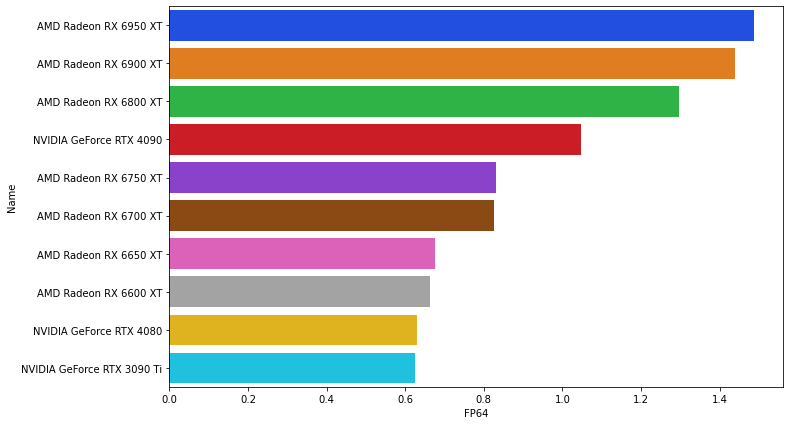

In [161]:
top10_FP64 = df.sort_values(by='FP64', ascending=False).head(10)
fig, axs = plt.subplots(figsize=(11,7))
sns.set_palette("bright")
sns.barplot(x="FP64", y="Name", data=top10_FP64)


<AxesSubplot:xlabel='FP32', ylabel='Name'>

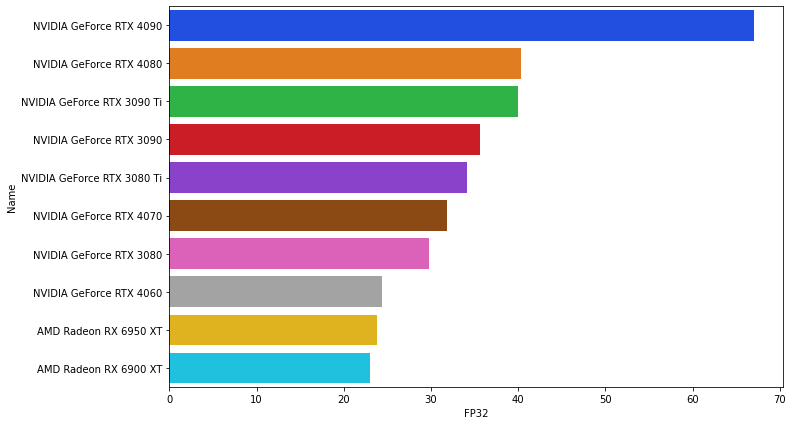

In [164]:
top10_FP32 = df.sort_values(by='FP32', ascending=False).head(10)
fig, axs = plt.subplots(figsize=(11,7))
sns.set_palette("bright")
sns.barplot(x="FP32", y="Name", data=top10_FP32)

<AxesSubplot:xlabel='FP16', ylabel='Name'>

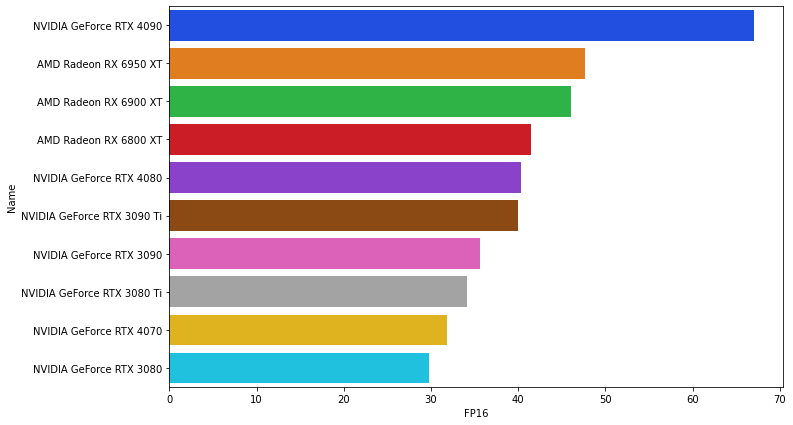

In [163]:
top10_FP16 = df.sort_values(by='FP16', ascending=False).head(10)
fig, axs = plt.subplots(figsize=(11,7))
sns.set_palette("bright")
sns.barplot(x="FP16", y="Name", data=top10_FP16)

Text(0.5, 1.01, 'EDA Overview')

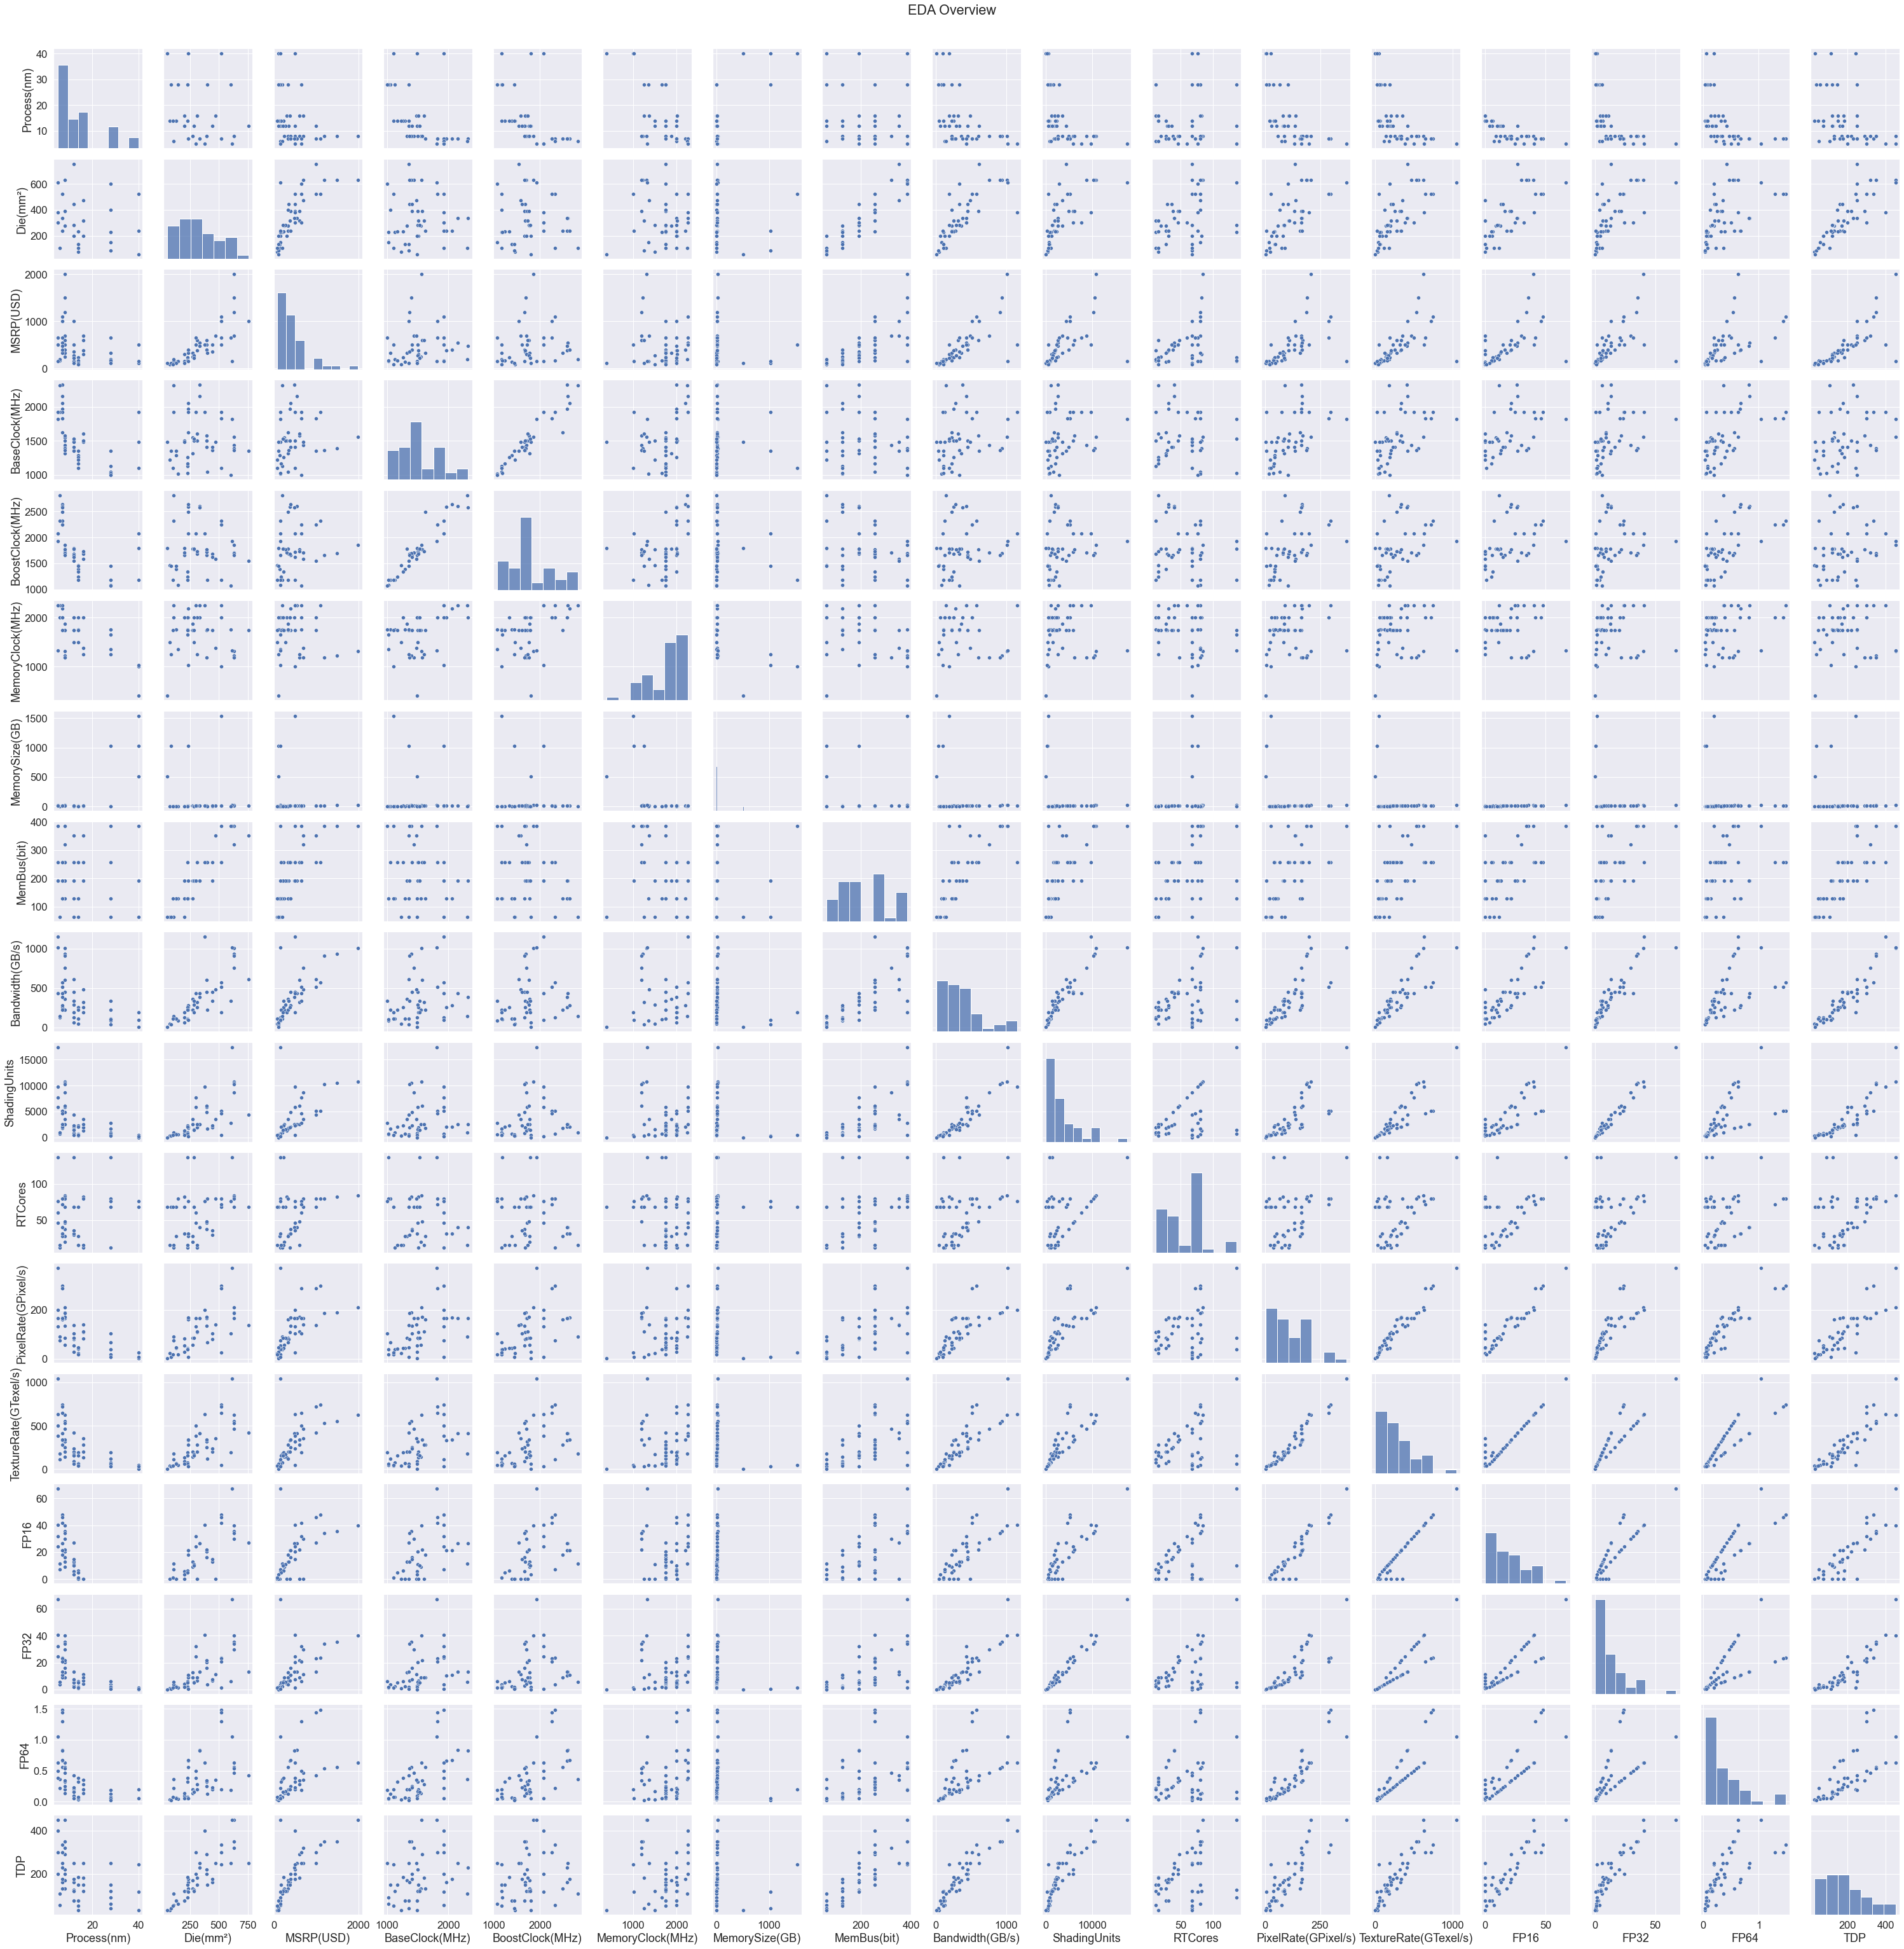

In [165]:
sns.set(font_scale = 1.5)
g = sns.pairplot(df)
g.fig.suptitle('EDA Overview', y = 1.01)